# Temperature Salinity Diagram

This notebook shows how to plot a temperature-salinity diagram which is weighted by volume using xhistogram. 

Output from both MOM5 or MOM6 can be used.

**Requirements**: The conda/analysis3 (or later) module on ARE. A session with 4 cores is sufficient for this example but more cores will be needed for larger datasets. 

Firstly, we load all required modules and start a client.

In [1]:
%matplotlib inline
import xarray as xr
import numpy as np
import cosima_cookbook as cc
from dask.distributed import Client
import gsw
from xhistogram.xarray import histogram as xhistogram
import cf_xarray as cfxr
import warnings
warnings.simplefilter('ignore')

## plotting
import matplotlib.pyplot as plt
import cmocean.cm as cmo
import matplotlib.colors as colors

In [2]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/39221/status,
Dashboard: /proxy/39221/status,Workers: 7
Total threads: 28,Total memory: 112.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46113,Workers: 7
Dashboard: /proxy/39221/status,Total threads: 28
Started: Just now,Total memory: 112.00 GiB
Comm: tcp://127.0.0.1:45779,Total threads: 4
Dashboard: /proxy/40195/status,Memory: 16.00 GiB
Nanny: tcp://127.0.0.1:33593,


## Load data

Select output from MOM5 or MOM6 and coordinates of meridional section.

In [3]:
lon = -25  # longitude of meridional section
lat = slice(-90, -37)  # latitude range of section

session = cc.database.create_session()

Next, choose an experiment of any resolution. Here, only 1 year is selected; if you want to use a longer time period, you might need more resources!

In [4]:
# dictionary of experiment name and time for mom5 and mom6
expt_args = {
    "mom5": {
        "expt": "01deg_jra55v13_ryf9091",
        "start_time": "1991-01-01",
        "end_time": "1991-12-31"},
    "mom6": {
        "expt": "panant-01-zstar-v13",
        "start_time": "1991-01-01",
        "end_time": "1991-12-31"}}

In [5]:
# dictionary of variable names and time for mom5 and mom6
vars_args = {
    "mom5": {
        "var_temp": 'temp',
        "var_salt": 'salt',
        "var_area": 'area_t'},
    "mom6": {
        "var_temp": 'thetao',
        "var_salt": 'so',
        "var_area": 'areacello'}}

We define below a few functions used to load output (temperature or salinity) and compute the histogram for the T-S diagram.

In [6]:
def gsw_SA_from_SP(salt, lon_name):
    """function to convert practical salinity to absolute salinity
    using the Gibbs SeaWater (GSW) Oceanographic Toolbox of TEOS-10
    (https://teos-10.github.io/GSW-Python/)
    
    input:
        -salt: practical salinity (array)
        -lon_name: name of the longitude (str)
    output:
        -salt_abs: absolute salinity (array)
    """
    pres = gsw.p_from_z(-salt.cf['vertical'], salt.cf['latitude'])
    salt_abs = gsw.SA_from_SP(salt, pres, salt[lon_name], salt.cf['latitude'])
    salt_abs.attrs = {'units': 'Absolute Salinity (g/kg)'}
    return salt_abs

In [7]:
# a function to load salinity
def load_salinity(model):
    salt = cc.querying.getvar(
        variable=vars_args[model].get('var_salt'), session=session, frequency='1 monthly',
        **expt_args[model])
    lon_name = salt.cf['longitude'].name
    # select longitude, latitude range and time
    salt = salt.cf.sel(longitude=lon, method='nearest').cf.sel(
        latitude=lat, time=slice(expt_args[model].get('start_time'),
                                 expt_args[model].get('end_time')))
    # convert from practical to absolute salinity
    salt = gsw_SA_from_SP(salt, lon_name)
    return salt

In [8]:
# a function to load temperature
def load_temperature(model):
    temp = cc.querying.getvar(
        variable=vars_args[model].get('var_temp'), session=session, frequency='1 monthly',
        **expt_args[model])
    # select longitude, latitude range and time
    temp = temp.cf.sel(longitude=lon, method='nearest').cf.sel(
        latitude=lat, time=slice(expt_args[model].get('start_time'),
                                 expt_args[model].get('end_time')))
    if model == 'mom5':
        temp = temp - 273.15
    elif model == 'mom6':
        # convert potential to conservative temperature
        temp = gsw.conversions.CT_from_pt(salt, temp)
        temp.name = 'temp'
    temp.attrs = {'units': 'Conservative temperature (°C)'}
    return temp

In [9]:
# a function to load area of grid cells
def load_grid_areas(model):
    area = cc.querying.getvar(
        variable=vars_args[model].get('var_area'), session=session, n=1,
        **expt_args[model])
    if model == 'mom5':
        area = area.drop(['geolon_t', 'geolat_t'])
    # select longitude and latitude range
    area = area.cf.sel(longitude=lon, method='nearest').cf.sel(
        latitude=lat)
    return area

In [10]:
# a function that computes the temperature and salinity bins for 2D histogram 
def compute_TS_bins(salt, temp, area):
    temp_bins = np.arange(np.floor(temp.min().values), np.ceil(temp.max().values), 0.5)
    salt_bins = np.arange(np.floor(salt.min().values), np.ceil(salt.max().values), 0.1)
    # for density contours in TS diagram
    temp_bins_mesh,salt_bins_mesh = np.meshgrid(temp_bins, salt_bins)
    TS_density = gsw.density.sigma2(salt_bins_mesh, temp_bins_mesh)
    # volume of grid cells to account for varying grid cells especially in the vertical
    vol = (temp.cf['vertical'] * area)

    # 2D histogram of temperature and salinity weighted by volume
    TS_hist = xhistogram(
        temp, salt, bins=(temp_bins, salt_bins), weights=vol)
    TS_hist = TS_hist.where(TS_hist != 0).compute()
    return TS_hist, TS_density, salt_bins_mesh, temp_bins_mesh 

Now let's select a model, load everything, and compute the TS diagram

## MOM5

In [11]:
model = 'mom5'  # 'mom5' or 'mom6'
salt = load_salinity(model)
temp = load_temperature(model)
area = load_grid_areas(model)

### Calculate and plot the TS diagram

In [12]:
TS_hist, TS_density, salt_bins_mesh, temp_bins_mesh = compute_TS_bins(salt, temp, area)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/dask/array/reductions.py:611: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(x_chunk, axis=axis, keepdims=keepdims)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/dask/array/reductions.py:611: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(x_chunk, axis=axis, keepdims=keepdims)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/dask/array/reductions.py:611: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(x_chunk, axis=axis, keepdims=keepdims)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/dask/array/reductions.py:611: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(x_chunk, axis=axis, keepdims=keepdims)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/dask/array/reductions.py:611: RuntimeWarning: All-NaN slice 

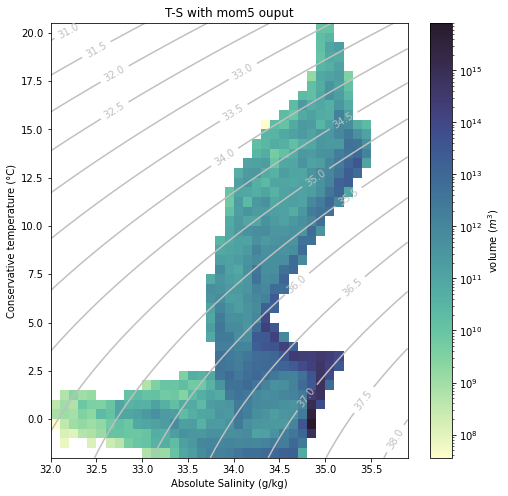

In [13]:
plt.figure(figsize=(8, 8))
# logarithmic colormap to show both TS bins with smaller and
# larger volumes (e.g. NADW, AABW)
norm=colors.LogNorm(
    vmin=TS_hist.min().values, vmax=TS_hist.max().values)
# volume weighted histogram of T and S
TS_hist.plot(cmap=cmo.deep, norm=norm,
             cbar_kwargs=dict(label='volume ($m^{3}$)'))
# density contours
cs = plt.contour(
    salt_bins_mesh, temp_bins_mesh, TS_density, colors='silver',
                 levels=np.arange(np.floor(TS_density.min()),
                                  np.ceil(TS_density.max()), .5))
plt.clabel(cs, inline=True)

plt.xlabel(salt.units)
plt.ylabel(temp.units)
plt.title("T-S with "+model+" ouput");

## MOM6

Now let's do the same but selecting `mom6` as our model.

In [14]:
model = 'mom6'  # 'mom5' or 'mom6'
salt = load_salinity(model)
temp = load_temperature(model)
area = load_grid_areas(model)
TS_hist, TS_density, salt_bins_mesh, temp_bins_mesh = compute_TS_bins(salt, temp, area)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/dask/array/reductions.py:611: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(x_chunk, axis=axis, keepdims=keepdims)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/dask/array/reductions.py:611: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(x_chunk, axis=axis, keepdims=keepdims)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/dask/array/reductions.py:611: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(x_chunk, axis=axis, keepdims=keepdims)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/dask/array/reductions.py:640: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/dask/array/reductions.py:640: RuntimeWarning: All-NaN slice 

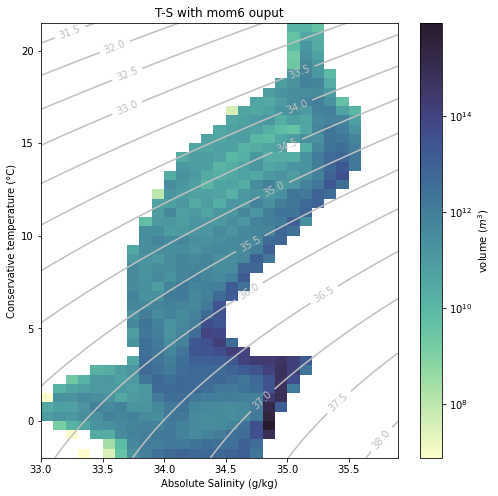

In [15]:
plt.figure(figsize=(8, 8))
# logarithmic colormap to show both TS bins with smaller and
# larger volumes (e.g. NADW, AABW)
norm=colors.LogNorm(
    vmin=TS_hist.min().values, vmax=TS_hist.max().values)
# volume weighted histogram of T and S
TS_hist.plot(cmap=cmo.deep, norm=norm,
             cbar_kwargs=dict(label='volume ($m^{3}$)'))
# density contours
cs = plt.contour(
    salt_bins_mesh, temp_bins_mesh, TS_density, colors='silver',
                 levels=np.arange(np.floor(TS_density.min()),
                                  np.ceil(TS_density.max()), .5))
plt.clabel(cs, inline=True)

plt.xlabel(salt.units)
plt.ylabel(temp.units)
plt.title("T-S with "+model+" ouput");